# 2018 Ranch Fire: Fire Scar Visualization and Land Cover Statistics 

Author: Haylee Oyler

### About

This notebook explores land cover change after the 2018 Mendocino Complex Fire knowns as the Ranch Fire that occurred in Mendocino County, California. It uses true and false color imagery to visualize the fire scar and the relative burn ratio. It also uses land use and land cover data from the USGS to calculate land cover statistics within the fire perimeter boundaries.

### Data
-   [CalFire Fire Perimeter Data](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)
    - The Ranch Fire perimeter data comes from CalFire's data portal. The accessed GeoDatabase includes information on the fire date, managing agency, cause, acres, and the geospatial boundary of the fire, among other information. This data was pre-processed to select only the Ranch fire boundary geometry.
  

-   [Landsat Data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)
    - The Landsat data comes from Microsoft's Planetary Computer Data Catalog. It is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite. 


- [Land Use and Land Cover Data](https://planetarycomputer.microsoft.com/dataset/gap#overview)
  - The LULC data comes from Microsoft's Planetary Computer Data Catalog. Specifically, the Gap Collection provided by the United States Geological Survey. It is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. 


#### *References*
-   Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6

-   California Department of Forestry and Fire Protection (CAL FIRE), calfire_all.gdb, 2024-11-17, retrieved from [CAL FIRE data portal.](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)



In [1]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches 
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
from shapely import box
from IPython.display import Image 
import scipy.stats as stats
import rasterio
from rasterio.plot import show

# MPC 
import pystac_client
import planetary_computer
import odc.stac
from pystac.extensions.eo import EOExtension as eo
from pystac.extensions.projection import ProjectionExtension

# Cal-Adapt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


## Fire Scar Visualization

We'll start by accessing the MPC data catalog to retrieve the Landsat data. We want to narrow down our region of interest to the bounding box of the Ranch Fire, so we'll import the fire perimeter data and extract the necessary coordinates for our query.

In [2]:
# Import Ranch Fire perimeter
ranch_fire = gpd.read_file(os.path.join('data', 'ranch_boundary.geojson'))
# river_fire = gpd.read_file(os.path.join('data', 'river_boundary.geojson'))

# Combine the two fire perimeters into one complex fire
# union_geom = ranch_fire.geometry.union(river_fire.geometry)

# Create a new geodataframe with the combined geometry
# mendocino = gpd.GeoDataFrame(geometry=[union_geom.unary_union], 
#                             crs=ranch_fire.crs)

# Get the bounding box of the entire complex fire
ranch_fire_bbox = list(ranch_fire.to_crs('epsg:4326').total_bounds)

# Set time period of interest
time_of_interest = "2018-10-01/2018-11-01"

In [3]:
# Open MPC data catalog connection
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=ranch_fire_bbox,
                        query={
                            # Images with less than 10% cloud cover
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 4 Items


In [4]:
# View different item options 
for item in items:
    cloud_cover = eo.ext(item).cloud_cover
    print(f"Item: {item.id} on {item.datetime.date()}, Cloud Cover: {cloud_cover}%")

# Select the item with the minimum cloud cover
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

Item: LC08_L2SP_045033_20181030_02_T1 on 2018-10-30, Cloud Cover: 0.02%
Item: LC08_L2SP_045032_20181030_02_T1 on 2018-10-30, Cloud Cover: 0.14%
Item: LC08_L2SP_045032_20181014_02_T1 on 2018-10-14, Cloud Cover: 1.98%
Item: LC08_L2SP_044033_20181007_02_T1 on 2018-10-07, Cloud Cover: 0.05%


In [5]:
# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]

# Load in the data from the stac item
post_burn_data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=ranch_fire_bbox
).isel(time=0)

Next, let's confirm that our fire perimeter looks correct and our data is matching accordingly

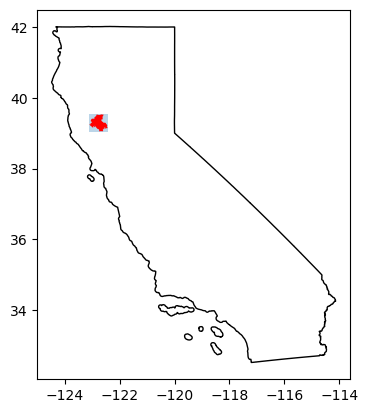

In [6]:
# Reproject data to match the CRS between our two datasets
ranch_fire = ranch_fire.to_crs("EPSG:4326")
post_burn_data = post_burn_data.rio.reproject("EPSG:4326")

# Confirm that the CRS of our data match
assert post_burn_data.rio.crs == ranch_fire.crs

# Create geo df from raster bounding box
data_bbox = gpd.GeoDataFrame(geometry = [box(*post_burn_data.rio.bounds())],
                            crs = post_burn_data.rio.crs)

ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

# Confirm that our bbox matches our fire perimeter
fig, ax = plt.subplots()

ca.plot(ax=ax, color='white', edgecolor ='black')
data_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
ranch_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

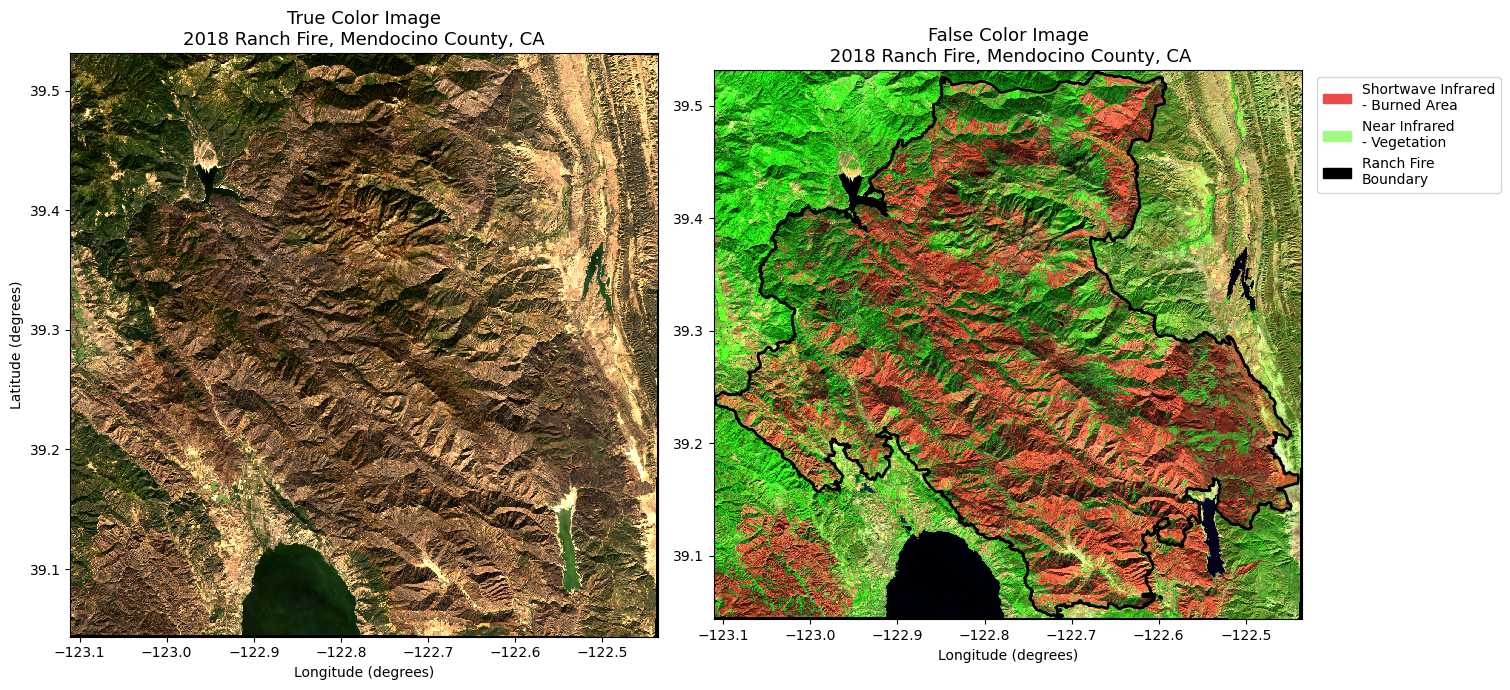

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# True color image
post_burn_data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=axes[0])

# mendocino.boundary.plot(ax=axes[0], 
#                         edgecolor='#000', 
#                         linewidth=2)

# Set titles and labels
axes[0].set_title("True Color Image\n2018 Ranch Fire, Mendocino County, CA", fontsize=13)
axes[0].set_xlabel('Longitude (degrees)')
axes[0].set_ylabel('Latitude (degrees)')

# False color image
post_burn_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=axes[1], robust=True)

# Plot the fire perimeter
ranch_fire.boundary.plot(ax=axes[1], 
                        edgecolor='#000', 
                        linewidth=2)

# Create a legend for the bands and boundary
legend_swir = mpatches.Patch(color="#eb4b4b", label='Shortwave Infrared\n- Burned Area')
legend_nir = mpatches.Patch(color="#a1fc81", label='Near Infrared\n- Vegetation')
legend_bound = mpatches.Patch(color="#000", label='Ranch Fire\nBoundary')

# Add legend to false color subplot
axes[1].legend(handles=[legend_swir, legend_nir, legend_bound], 
                bbox_to_anchor=(1.35, 1), 
                fontsize=10)

# Set title and labels
axes[1].set_title('False Color Image\n 2018 Ranch Fire, Mendocino County, CA', fontsize=13)
axes[1].set_xlabel('Longitude (degrees)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

### Fire Severity: NBR and RBR

Calculate the normalized burn ratio and relative burn ratio for the Ranch Fire. The normalized burn ratio uses the spectral reflectance of healthy and burned vegetation to identify areas of high severity fire. Near infrared radiation ($NIR$) is highly reflective in healthy vegetation and short wave infrared ($SWIR$) is highly reflective in unhealthy or burned vegetation.

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$

The relative burn ratio is an alternate way to visualize fire severity that takes into account the overall variation in vegetation before the fire event. Scaling by pre-fire conditions allows you to compare vegetation loss across different intital vegetation conditions. 

$$ RBR = \frac{\delta NBR}{NBR_{prefire} + 1.001} $$

For this visualization, I will be creating a map of $RBR$ for the Ranch Fire. To do this, will need to get data before the fire event to analyze pre-fire conditions. 

In [13]:
# Change our time period of interest to before the fire
time_of_interest = "2018-01-01/2018-07-01"

# Search MPC catalog 
search = catalog.search(collections=['landsat-c2-l2'],
                        datetime=time_of_interest,
                        bbox=ranch_fire_bbox,
                        query={
                            # Images with less than 10% cloud cover
                            "eo:cloud_cover": {"lt": 10},
                            # Landsat 8 and 9 were chosen to avoid landsat 7 data collection failure
                            "platform": {"in": ["landsat-8", "landsat-9"]}
                            }
                        )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

# Select the item with the minimum cloud cover
pre_burn_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {pre_burn_item.id} from {pre_burn_item.datetime.date()}"
    + f" with {pre_burn_item.properties['eo:cloud_cover']}% cloud cover"
)

# Select bands of interest for visualization
bands_of_interest = ["nir08", "red", "green", "blue", "swir16", "swir22"]
pre_burn_data = odc.stac.stac_load(
    [pre_burn_item], bands=bands_of_interest, bbox=ranch_fire_bbox
).isel(time=0)

# Confirm CRS matches the post-burn data
pre_burn_data = pre_burn_data.rio.reproject("EPSG:4326")
assert post_burn_data.rio.crs == pre_burn_data.rio.crs

Returned 12 Items
Choosing LC08_L2SP_045033_20180507_02_T1 from 2018-05-07 with 0.04% cloud cover


In [ ]:
# Pre-burn NBR
pre_swir = pre_burn_data["swir22"].astype("float")
pre_nir = pre_burn_data["nir08"].astype("float")
pre_nbr = (pre_nir - pre_swir) / (pre_nir + pre_swir)

# Post-burn NBR
post_swir = post_burn_data["swir22"].astype("float")
post_nir = post_burn_data["nir08"].astype("float")
post_nbr = (post_nir - post_swir) / (post_nir + post_swir)

# Difference in NBR
dnbr =  pre_nbr - post_nbr

# Relative burn ratio
rbr = dnbr / (pre_nbr + 1.001)

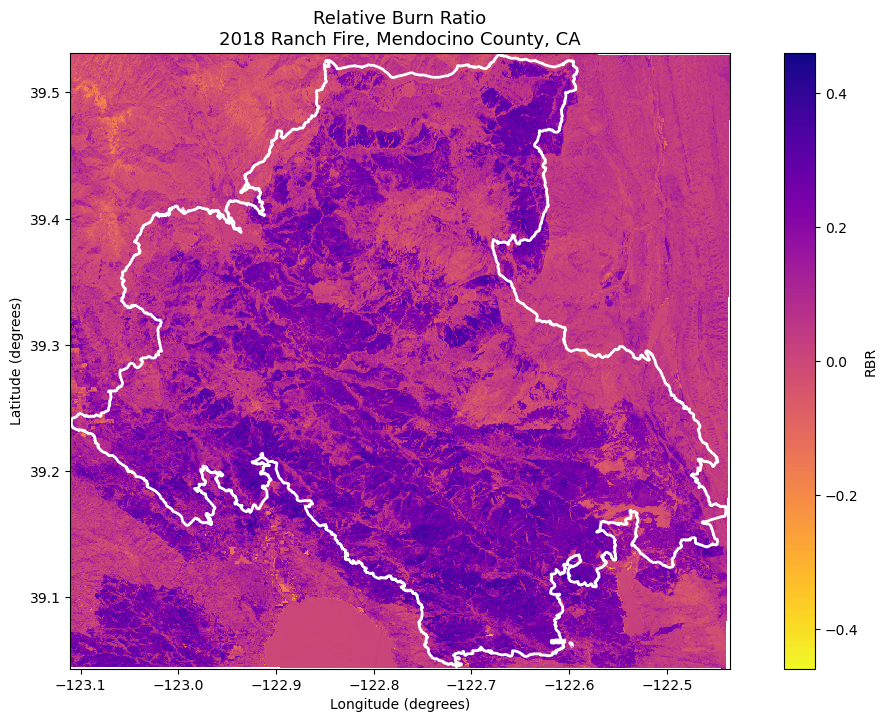

In [21]:
# View RBR across the fire scar 
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the RBR data directly (they should already have matching CRS)
rbr.plot.imshow(ax=ax, cmap="plasma_r",
                cbar_kwargs={
                    'label':'RBR',
                })

# Plot the fire perimeter (convert mendocino to match rbr's CRS if needed)
ranch_fire.boundary.plot(ax=ax, 
                        edgecolor='#fff', 
                        linewidth=2, 
                        label='Mendocino Complex Fire Boundary')

ax.set_title("Relative Burn Ratio\n2018 Ranch Fire, Mendocino County, CA", fontsize=13)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
plt.show()

Both the false color imagery and the $RBR$ imagery provide ways to understand the scope and magnitude of fire across landscapes. But what if you were interested in understanding more detail about the area affected? For this, we'll turn to data on **and cover**.

## Land Cover Statistics

To understand what biomes and land cover types were affected by the fire, we'll access a different MPC collection: the [USGS Gap Land Cover data](https://www.usgs.gov/programs/gap-analysis-project/science/land-cover-vision). This data contains information on specific land use and land cover (lulc) types that will let us get more information about the Ranch Fire's impact.

In [ ]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog 
search = catalog.search(collections=['gap'], 
                        bbox=ranch_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")

In [ ]:
# Select unique search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

In [ ]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)

# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

In [ ]:
lulc = lulc.rio.reproject("EPSG:4326")
assert lulc.rio.crs == mendocino.crs

In [ ]:
# Create colormap for visualization
with rasterio.open(item.assets["data"].href) as dataset:
    colormap = dataset.colormap(1)

keys = list(colormap.keys())
keys.sort()

assert keys == list(range(0, len(keys)))  

color_list = list([float(v) / float(255) for v in colormap[key]] for key in keys)
cmap = ListedColormap(color_list)


In [ ]:
# Write no-data value to avoid error later on
# lulc = lulc.rio.write_nodata(0)

# Clip to fire perimeter
lulc_clipped = lulc.rio.clip(mendocino.geometry, drop=True)

# Convert to numpy for visualization with the correct colormap
lulc_data = lulc_clipped.squeeze().values

# Get unique values from the clipped data
unique_values = np.unique(lulc_data)
unique_values = unique_values[unique_values != 0]  # Remove no-data

# Create a subset colormap and class labels for only the values present in clipped data
subset_colors = [cmap.colors[v] for v in unique_values]
subset_cmap = ListedColormap(subset_colors)

classes = item.properties["label:classes"][0]["classes"]

# Create patches only for classes present in the clipped data
patches = []
for i, v in enumerate(unique_values):
    if v < len(classes):
        patches.append(Patch(color=subset_colors[i], label=classes[v]))
    else:
        patches.append(Patch(color=subset_colors[i], label=f'Class {v}'))

# Now plot with the subset colormap
fig, ax = plt.subplots(figsize=(13, 12))
ax.set_axis_off()

# Map the clipped data values to the subset colormap indices
mapped_data = np.zeros_like(lulc_data)
for i, v in enumerate(unique_values):
    mapped_data[lulc_data == v] = i

# Convert mapped data to color array for visualization
color_data = np.moveaxis(
    subset_cmap(mapped_data), [0, 1, 2], [1, 2, 0]
)

_ = show(color_data, ax=ax, transform=lulc_clipped.rio.transform(), interpolation="none")

mendocino.boundary.plot(ax=ax, color='red', linewidth=2)

fig.legend(handles=patches, bbox_to_anchor=(1.38, 0.876))

plt.show()

## Clip Raster to Geometry

In [ ]:
# # Match CRS and verify update
# ranch_fire_match = ranch_fire.to_crs(lulc.rio.crs)
# assert ranch_fire_match.crs == lulc.rio.crs

# # Clip large raster to detailed geometry in two steps
# lulc_step1 = lulc.rio.clip_box(*ranch_fire_match.total_bounds)
# lulc_step2 = lulc_step1.rio.clip(ranch_fire_match.geometry)  # Produces RuntimeWarning

# # ------------------------------------------------------
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# # Plot the first clipped raster
# lulc_step1.plot(ax=ax[0])
# ax[0].set_title("Step 1: Clip to Bounding Box")
# ax[0].axis("off")

# # Plot the second clipped raster
# lulc_step2.plot(ax=ax[1])
# ax[1].set_title("Step 2: Clip to Detailed Geometry")
# ax[1].axis("off")

# plt.show()

Notice a RunTimeWarning appeared when we clipped the raster. This occurs because the `rio.clip()` function tries to fill values outside the fire perimeter with np.nan. However, as we previously saw, our raster’s data type is uint16 (16 bits unsigned integer). The cast issue appears since np.nan is a float (decimal number) and it cannot be casted as a uint16. To make sure the clipping operator fills in any pixels with the adequate no-data value, let’s manually set it:

In [ ]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

In [ ]:
# Re-clip now that we've fixed the no-data issue
lulc_clip = (lulc.rio.clip_box(*mendocino.total_bounds)
                .rio.clip(mendocino.geometry)
                )

In [ ]:
# Get the number of pixels per class
values, counts = np.unique(lulc_clip, return_counts = True)

# Store values and counts in a dataframe
pix_counts = pd.DataFrame({
    'code' : values,
    'pixel_count' : counts,
})

# Import the class labels dataset
labels = pd.read_csv(os.path.join('data',
                    'GAP_National_Terrestrial_Ecosystems.csv')
                    )

# Join the pixel count and labels dfs
pix_label = pd.merge(pix_counts, labels, how="left", on='code')
pix_label.head()

Use the labels data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

In [ ]:
# lulc_clip.rio.resolution()

In [ ]:
# Filtering out the 'no-data' class
valid_classes = pix_label[pix_label['code'] != 0].copy()

# Find the total pixels to calculate land cover percentages
total_pixels = valid_classes['pixel_count'].sum()

# Calculate land cover percentage
valid_classes['percentage'] = (valid_classes['pixel_count'] / total_pixels) * 100
valid_classes = valid_classes[['class_label', 'percentage']].sort_values(by='percentage', ascending=False).set_index('class_label')

# Get the raster resolution (pixel size)
pixel_width = abs(lulc_clip.rio.resolution()[0])  # Width in map units
pixel_height = abs(lulc_clip.rio.resolution()[1])  # Height in map units
pixel_area = pixel_width * pixel_height  # Area per pixel in map units²

print(f"Pixel resolution: {pixel_width} x {pixel_height}")
print(f"Pixel area: {pixel_area} map units²")
print(f"CRS: {lulc_clip.rio.crs}")

# Check what the map units are (likely meters for this projection)
print(f"CRS info: {lulc_clip.rio.crs.to_string()}")
# Convert pixel area from m² to km² (assuming map units are meters)
pixel_area_km2 = pixel_area / 1_000_000  # Convert m² to km²

In [ ]:
# Plot the land cover statistics
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=valid_classes.head(10), # Only interested in the top 10 most common classes
                y='class_label',  
                x='percentage',
                color='#40A135',
                edgecolor='black',
                orient='h'
                )

# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%.1f%%')  

# Format x-axis tick labels
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
# Add x-axis gridlines
ax.set_axisbelow(True) # Set below the bars
ax.xaxis.grid(True, which='major', linestyle='--', color='lightgrey')

# Format y-ticks
yticks = list(range(10))  # Added to avoid userwarning setting ytick labels
ax.set_yticks(yticks)
ax.set_yticklabels([
    'Mediterranean California Dry-Mesic\nMixed Conifer Forest and Woodland',
    'Northern and Central California\nDry-Mesic Chaparral',
    'California Lower Montane Blue\nOak-Foothill Pine Woodland and Savanna',
    'California Central Valley Mixed Oak Savanna',
    'California Coastal Live Oak\nWoodland and Savanna',
    'California Xeric Serpentine Chaparral',
    'Introduced Upland Vegetation\n- Annual Grassland',
    'Developed, Open Space',
    'California Northern Coastal Grassland',
    'Mediterranean California Lower Montane\nBlack Oak-Conifer Forest and Woodland'
])

# Remove plot borders for clarity
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Title and labels
ax.set_title('Distribution of Land Cover within the Ranch Fire Perimeter\n(2011 USGS National Terrestrial Ecosystems Data)', fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')

plt.yticks(fontsize=11)
# ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Get the raster resolution (pixel size)
pixel_width = abs(lulc_clip.rio.resolution()[0])  # Width in map units
pixel_height = abs(lulc_clip.rio.resolution()[1])  # Height in map units
pixel_area = pixel_width * pixel_height  # Area per pixel in map units²

print(f"Pixel resolution: {pixel_width} x {pixel_height}")
print(f"Pixel area: {pixel_area} map units²")
print(f"CRS: {lulc_clip.rio.crs}")

# Check what the map units are (likely meters for this projection)
print(f"CRS info: {lulc_clip.rio.crs.to_string()}")

In [ ]:
# Convert pixel area from m² to km² (assuming map units are meters)
# pixel_area_km2 = pixel_area / 1_000_000  # Convert m² to km²

# # Find developed land classes in your data
# # Look at your pix_label dataframe to identify developed classes
# print("Available land cover classes:")
# print(pix_label[['class', 'class_label']].head(10))

# # Filter for developed classes (you'll need to identify the correct class codes)
# # Common developed class codes might be in ranges like 9100-9999
# developed_classes = pix_label[pix_label['class_label'].str.contains('Developed|Urban', case=False, na=False)]
# print("\nDeveloped classes found:")
# print(developed_classes)

# # Calculate total developed area
# if not developed_classes.empty:
#     total_developed_pixels = developed_classes['pixel_count'].sum()
#     developed_area_km2 = total_developed_pixels * pixel_area_km2
    
#     print(f"\nDeveloped area calculation:")
#     print(f"Total developed pixels: {total_developed_pixels}")
#     print(f"Pixel area: {pixel_area_km2:.6f} km²")
#     print(f"Total developed area: {developed_area_km2:.2f} km²")
# else:
#     print("No developed classes found. Check class names manually.")

## Cal-Adapt Climate Data

In [ ]:
# Open connection to the Cal-Adapt data catalog
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

# View the data frame
cat_df = catalog.df

In [ ]:
# # Print out all unique grid labels
# print(cat_df.grid_label.unique())

# # Print out all unique variable_id values
# print(cat_df.variable_id.unique())

# # Print out all unique table_id values
# print(cat_df.table_id.unique())

# # Display all the variables available at different time resolutions
# # daily
# # print(cat_df[cat_df["table_id"] == "day"].variable_id.unique())

# # # monthly
# print(cat_df[cat_df["table_id"] == "mon"].variable_id.unique())


### Model Selection: LOCA2

Cal-Adapt's catalog has available downscaling techniques: LOCA2 and WRF.

**LOCA2**: Localized Constructed Analogs that use a statistical approach to downscaling large climate models. This uses high resolution local spatial data to "fill in" the gaps of the lower resolution global climate model. 

**WRF**: Weather Research and Forecasting model that uses a dynamic approach to downscaling.

In [ ]:
# activity_id: which downscaling technique do you want?
activity_id = ["LOCA2"]

# experiment_id: which historical/future scenario do you want?
experiment_ids = ["historical", "ssp370"]

source_id = ['CESM2-LENS']

# table_id: which time resolution do you want?
table_id = ["day"]

# variable_id: which variable do you want?
# variable_id = ["tasmax"]

In [ ]:
# Search through catalog, store results
loca = catalog.search(activity_id=activity_id, experiment_id=experiment_ids, source_id=source_id,
                    table_id=table_id)
                    # variable_id=variable_id)

# Display data frame associated with results
loca_df = loca.df
loca_df

In [ ]:
# Select member id r1i1p1f1	
# loca_data = xr.open_zarr(
# 	loca_df.loc[loca_df['member_id'] == 'r1i1p1f1', 'path'].iloc[0],
# 	storage_options={'anon': True}
# )

In [ ]:
# View the data in tasmax
# loca_data.tasmax

In [ ]:
# Select CESM2 historical data
loca_hist = loca_df[loca_df["experiment_id"] == "historical"]

# Select CESM2 SSP3-7.0 projected data
loca_ssp = loca_df[loca_df["experiment_id"] == "ssp370"]

In [ ]:
# Make a list of the unique ensemble members for the historical and projected data
mems_hist = loca_hist.member_id.unique()
mems_ssp = loca_ssp.member_id.unique()

# Find the common member ids using set, then convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [ ]:
# # Define an empty list
# cesm2_loca_data = []

# # Get fire perimeter bounds in lat/lon (you already have this)
# ranch_fire_bounds_4326 = ranch_fire.to_crs('epsg:4326').total_bounds
# min_lon, min_lat, max_lon, max_lat = ranch_fire_bounds_4326

# # Loop over all common ensemble members
# for mem in range(len(common_mems)):
#     print(common_mems[mem])

#     # True/False array showing whether or not the member_id matches our member of interest
#     hist_mask = loca_hist['member_id'] == common_mems[mem]
#     # extract (first) location where the mask is True
#     hist_loc = loca_hist['member_id'][hist_mask].index[0]
    
#     # Do the same thing for the SSP ensemble
#     ssp_mask = loca_ssp['member_id'] == common_mems[mem]
#     ssp_loc = loca_ssp['member_id'][ssp_mask].index[0]
    
#     # Store HISTORICAL data as xarray and clip to region of interest
#     hist_data = xr.open_zarr(loca_hist['path'][hist_loc], storage_options={'anon': True})
#     hist_data = hist_data.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
    
#     # Store SSP3-7.0 data as xarray and clip to region of interest
#     ssp_data = xr.open_zarr(loca_ssp['path'][ssp_loc], storage_options={'anon': True})
#     ssp_data = ssp_data.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
    
#     # Concatenate historical, SSP information
#     temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
#     # Add to list
#     cesm2_loca_data.append(temp_data)

# # Concatenate the list into a single xarray object
# cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# # Store the actual member information as values of the new dimension
# cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

In [ ]:
# # Define an empty list
# cesm2_loca_data = []

# # Loop over all common ensemble members
# for mem in range(len(common_mems)):
#     print(common_mems[mem])

#     # True/False array showing whether or not the member_id matches our member of interest
#     hist_mask = loca_hist['member_id'] == common_mems[mem]
#     # extract (first) location where the mask is True
#     hist_loc = loca_hist['member_id'][hist_mask].index[0]
    
#     # Do the same thing for the SSP ensemble
#     ssp_mask = loca_ssp['member_id'] == common_mems[mem]
#     ssp_loc = loca_ssp['member_id'][ssp_mask].index[0]
    
#     # Store HISTORICAL data as xarray
#     hist_data = xr.open_zarr(loca_hist['path'][hist_loc], storage_options={'anon': True})
    
#     # Store SSP3-7.0 data as xarray
#     ssp_data = xr.open_zarr(loca_ssp['path'][ssp_loc], storage_options={'anon': True})
    
#     # Concatenate historical, SSP information
#     temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
#     # Add to list
#     cesm2_loca_data.append(temp_data)

# # Concatenate the list into a single xarray object
# cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# # Store the actual member information as values of the new dimension
# cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

In [ ]:
# # Calculate the ensemble means
# cesm2_loca_diff = cesm2_loca_diff.mean(dim="member")
# # cesm2_wrf_diff = cesm2_wrf_diff.mean(dim="member")


In [ ]:
# # Display units for LOCA2, WRF data
# print(cesm2_locadata_late.tasmax.units)

# # print(cesm2_wrfdata_late.prec.units)